# Tully-Fisher Relation of galaxies in the Coma Cluster

Using the observations made as part of the Peculiar Velocity Survey, create the Tully-Fisher relation for those galaxies in the Coma Cluster.

In [3]:
import os

#from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
#from astropy.wcs import WCS
#from astropy.visualization.wcsaxes import SphericalCircle

#import psycopg2

import numpy as np

# try:
#     import numdifftools as ndt
# except ModuleNotFoundError as e:
#     ! pip install --user numdifftools
#     import numdifftools as ndt
    
from scipy.optimize import minimize, curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
mpl.rc('font', size=12)
#mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning=0)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [5]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

## Read in Coma cluster targets

Generated in the `PV_coma_targets` notebook

In [6]:
bad_sga_ids = [30149, 474614, 545858, 653059, 811359, 900049, 972260, 1393079]

In [7]:
inComa_sga_table = Table.read('cache/tf_targets_coma_sga.fits', format='fits')

## Cut `SGA_IDs` using results from visual inspection

In [8]:
len(np.unique(inComa_sga_table['SGA_ID']))

113

In [9]:
for bad_sga_id in bad_sga_ids:
    indices = np.where(inComa_sga_table['SGA_ID'] == bad_sga_id)
    inComa_sga_table.remove_rows(indices)

In [10]:
len(np.unique(inComa_sga_table['SGA_ID']))

105

In [14]:
inComa_sga_table[:1]

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
TFT,6443,39628449261815639,194.015001968576,28.4347616870916,0,120,194.014992822247,28.4347575427582,0.0228077753473186,9.49692763345357e-06,GALAXY,12502.420789832,0,SGA-2020 6443,2MASXJ12560357+2826049,3798694,194.0150415,28.434759200000002,E,0.15,0.42953643,0.52966344,0.022773754,23.495481,16.702,False,LEDA-20181114,1749,2MASXJ12560357+2826049,1,True,194.0150415,28.434759200000002,0.42953643,1940p285,194.01499282224725,28.434757542758188,0.5758262,SB26,178.74611,0.5289391,194.0149013047641,28.43482627995438,11.529113,3.4933767,3.4790735,3.5417385,6.7043676,7.8427553,9.000888,10.051459,10.989381,12.259024,13.601412,15.212001,17.274786,16.533848,15.79303,15.308514,16.449266,15.712977,15.225233,16.390287,15.657084,15.167129,16.35449,15.6234045,15.132558,16.331707,15.60235,15.110845,16.310932,15.585337,15.0910425,16.299269,15.57684,15.080532,16.28742,15.564971,15.069217,16.278936,15.554956,15.059705,0.095610216,0.095818155,0.104093984,0.11963359,0.09470798,0.12928808,0.14805332,0.1717031,0.20933938,0.03951728,0.0422584,0.039743226,0.037378095,0.040008463,0.03761356,0.035762083,0.038332522,0.03601092,0.03476994,0.03730794,0.03504701,0.034159563,0.036694754,0.03445771,0.033523172,0.03611823,0.03383837,0.0332151,0.035883322,0.033557374,0.032830115,0.035464935,0.033186853,0.032

## Calculate the rotational velocities

And store those at $0.33R_{26}$

Also, remove those with a velocity > 5000 km/s

In [15]:
sga_ids_vel_cuts = []

rmag = []
drmag = []
vmax = []
dvmax = []

for i, sga_id in enumerate(np.unique(inComa_sga_table['SGA_ID'])):
    # if sga_id == 474614:
    #     print('skipped')
    #     continue
    galaxy_list = inComa_sga_table[inComa_sga_table['SGA_ID'] == sga_id]
    # print
    #print(i+1, sga_id)
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    r26 = 0.5 * float(sga_galaxy['D26'])*u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26
    
    zc, zc_err = sga_galaxy['Z'], sga_galaxy['ZERR']
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = c * dz
    dv_err = c * dz_err
    
    good_vel = dv < 5000
    # print(good_vel[0], sga_id)
    
    if np.sum(good_vel) > 0:
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26])
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2))

            rmag.append(float(sga_galaxy['R_MAG_SB26']))
            drmag.append(float(sga_galaxy['R_MAG_SB26_ERR']))
            vmax.append(v033)
            dvmax.append(dv033)
            sga_ids_vel_cuts.append(sga_id)
    # break
#print('mag:', rmag)
#print('vel:', vmax)
#print('dv:', dvmax)

77


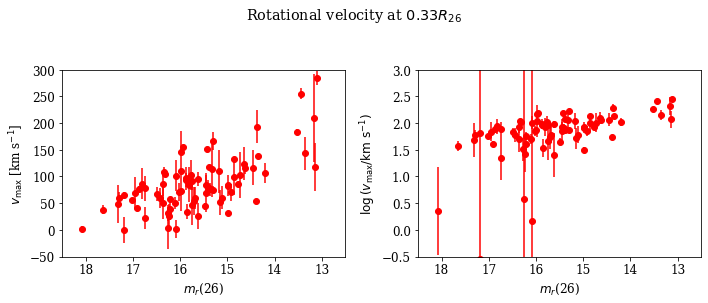

In [16]:
rmag = np.asarray(rmag)
drmag = np.asarray(drmag)
vmax = np.asarray(vmax)
dvmax = np.asarray(dvmax)

isrmeas = rmag > 0

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.errorbar(rmag[isrmeas], vmax[isrmeas], yerr=dvmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylim=(-50,300),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

ax.errorbar(rmag[isrmeas], log10vmax[isrmeas], xerr = drmag[isrmeas], yerr=dlog10vmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3))

fig.suptitle(r'Rotational velocity at $0.33R_{26}$', y=1.05)
fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

In [18]:
len(sga_ids_vel_cuts)

81

## Cuts on inclination angle and morphology

In [19]:
sga_ids_clean = []

rmag_clean = []
drmag_clean = []
vmax_clean = []
dvmax_clean = []

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

inComa_sga_table['cosi'] = np.sqrt((inComa_sga_table['BA']**2 - q0**2)/(1 - q0**2))
inComa_sga_table['cosi'][np.isnan(inComa_sga_table['cosi'])] = 0 # Objects with b/a < 0.2

#i = 0

# for sga_id in np.unique(inComa_sga_table['SGA_ID']):
for sga_id in sga_ids_vel_cuts:
    galaxy_list = inComa_sga_table[inComa_sga_table['SGA_ID'] == sga_id]
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    
    morphtype = str(sga_galaxy['MORPHTYPE'])
    
    cosi = float(sga_galaxy['cosi'])
    
    r26 = 0.5 * float(sga_galaxy['D26']) * u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26

    # Cut any suspected ellipticals
    if morphtype.startswith('E') or morphtype.startswith('S0') or morphtype.startswith('I'):
        continue
               
    # Inclination cut
    if cosi > cosi_max:
        continue
        
    #i += 1
    #print(i, sga_id, cosi)
    
    zc, zc_err = float(sga_galaxy['Z']), float(sga_galaxy['ZERR'])
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = 3e5 * dz
    dv_err = 3e5 * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
    
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
        
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26]) / np.sqrt(1 - cosi**2)
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2)) / np.sqrt(1 - cosi**2)

            rmag_clean.append(float(sga_galaxy['R_MAG_SB26']))
            drmag_clean.append(float(sga_galaxy['R_MAG_SB26_ERR']))
            vmax_clean.append(v033)
            dvmax_clean.append(dv033)
            sga_ids_clean.append(sga_id)
    
#inComa_sga_table[['SGA_ID', 'BA', 'cosi']].show_in_notebook()
print(len(rmag_clean))

/tmp/ipykernel_61608/3195127034.py:11: RuntimeWarning: invalid value encountered in sqrt
  inComa_sga_table['cosi'] = np.sqrt((inComa_sga_table['BA']**2 - q0**2)/(1 - q0**2))


56


In [20]:
len(sga_ids_vel_cuts)

81

## Inspecting rotational velocities and corresponding uncertainties

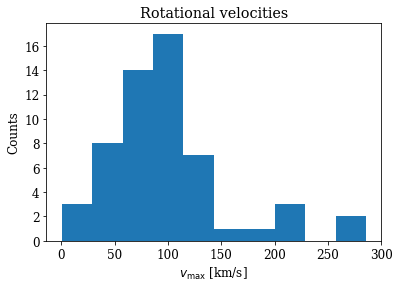

In [13]:
plt.hist(vmax_clean)
plt.xlabel(r'$v_\mathrm{max}$ [km/s]')
plt.ylabel('Counts')
plt.title('Rotational velocities')
plt.show()

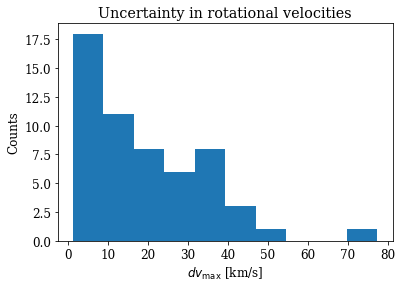

In [14]:
plt.hist(dvmax_clean)
plt.xlabel(r'$dv_\mathrm{max}$ [km/s]')
plt.ylabel('Counts')
plt.title('Uncertainty in rotational velocities')
plt.show()

In [21]:
rmag_clean_new = []
drmag_clean_new = []
vmax_clean_new = []
dvmax_clean_new = []
sga_ids_clean_new = []

# Remove points with high uncertainty
for i in range(len(sga_ids_clean)):
    if i == 7 or i== 40 or i== 53:
        continue
    rmag_clean_new.append(rmag_clean[i])
    drmag_clean_new.append(drmag_clean[i])
    vmax_clean_new.append(vmax_clean[i])
    dvmax_clean_new.append(dvmax_clean[i])
    sga_ids_clean_new.append(sga_ids_clean[i])

In [22]:
len(rmag_clean_new)

53

## Fitting using `scipy.optimize.minimize`

Segev's code

In [23]:
rmag_clean = np.asarray(rmag_clean_new)
drmag_clean = np.asarray(drmag_clean_new)
vmax_clean = np.asarray(vmax_clean_new)
dvmax_clean = np.asarray(dvmax_clean_new)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

# x = rmag_clean[isrmeas_clean]
# y = log10vmax_clean[isrmeas_clean]
# xerr = drmag_clean[isrmeas_clean]
# yerr = dlog10vmax_clean[isrmeas_clean]

In [53]:
# Randomly sample each point assumign uncertainties are Gaussian,
# fit a straight line using the l1 norm without weighting by the error
# to remain robust against outliers.

def l1norm_noerror(pars, x, y):
    '''
    Linear fit that uses the l1-norm without normalizing by measurement uncertainties.
    '''
    a, b = pars
    return np.sum(np.abs(y - a - b*x))

def fit_tfr(r, dr, logv, dlogv):
    fmin = 1e99
    a, b = 5, -0.15
    hess_inv = np.ones((2,2))
    succ_res = None
    slope = []
    yint = []
    for i in range(100000):
        x_arr = np.random.normal(r, dr)
        y_arr = np.random.normal(logv, dlogv)
        
        res = minimize(l1norm_noerror, 
                       [a, b], 
                       args=(x_arr, y_arr),# dlogv),
                       method='L-BFGS-B', 
                       bounds=[[-10,10], [-1., 1.]])
        
        if res.fun < fmin and res.success:
            # print('Successful fit')
            succ_res = res.copy()
            fmin = res.fun
            a, b = res.x
            hess_inv = res.hess_inv
            slope.append(b)
            yint.append(a)
            
    if succ_res is None:
        print('No successful fits')
    # else:
    #     print(succ_res)
    
    return yint, slope

In [54]:
# Log-likelihood
def loglike(theta):
    a, b, lnf = theta
    model = a + b*x
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    
    return -0.5 * (np.sum((y-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

# Define a negative LL for minimizers.
nloglike = lambda theta: -loglike(theta)

In [55]:
a, b = fit_tfr(rmag_clean[isrmeas_clean], drmag_clean[isrmeas_clean], log10vmax_clean[isrmeas_clean], dlog10vmax_clean[isrmeas_clean])

In [52]:
np.mean(b), np.std(b)

(-0.13296122032882077, 0.014897949926797542)

Obtained values:
- -0.14665247619339644, 0.009119988577416036
- -0.13296122032882077, 0.014897949926797542

(array([4., 0., 3., 0., 0., 0., 0., 0., 0., 3.]),
 array([4.07705473, 4.13252488, 4.18799503, 4.24346518, 4.29893533,
        4.35440548, 4.40987563, 4.46534578, 4.52081593, 4.57628608,
        4.63175622]),
 <BarContainer object of 10 artists>)

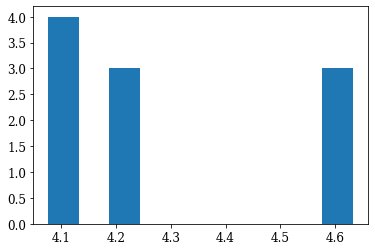

In [56]:
plt.hist(a)

In [47]:
np.mean(a)

4.2969955561164985

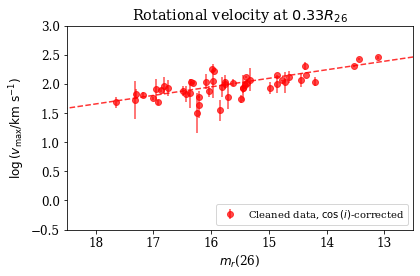

In [50]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

a_fit, b_fit = np.mean(a), np.mean(b)
r = np.arange(12.5,18.6,0.1)
ax.plot(r, a_fit + b_fit*r, 'r--', alpha=0.8)

ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity at $0.33R_{26}$')

ax.legend(loc='lower right', fontsize=10)
fig.savefig('cache/Coma_TFR_gaussian.png', transparent = True)

In [48]:
p0 = [4., -1., 1.]

bestfit = minimize(nloglike, p0, method='L-BFGS-B',
                   bounds=((0.,10.),
                           (-10.,0.),
                           (-10.,10.)))

bestfit

      fun: -69.80078192640372
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.54898317e-04, 2.54658517e-03, 1.42108548e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 160
      nit: 16
     njev: 40
   status: 0
  success: True
        x: array([ 4.14286996, -0.13665286, -2.85993172])

In [51]:
hessian = ndt.Hessian(loglike)
hess_ll = hessian(bestfit.x)
hess_inv = np.linalg.inv(hess_ll)

labels = ['y-intercept', 'slope', 'lnf']

uncertainty = np.sqrt(np.diag(-hess_inv))

for i in range(3):
    print('{:<14s} = {:9.4f} +- {:6.4f}'.format(labels[i], bestfit.x[i], uncertainty[i]))

y-intercept    =    4.1429 +- 0.2979
slope          =   -0.1367 +- 0.0189
lnf            =   -2.8599 +- 0.1353


In [44]:
# def fit_tfr(r, logv, dlogv):
#     fmin = 1e99
#     a, b, lnf = 4., -1., 1.
#     hess_inv = np.ones((3,3))
    
#     succ_res = None
    
#     # Try a large number of random seeds to ensure a decent fit.
#     for i in range(1000):
#         _a, _b, _lnf = np.random.uniform(-10,10), np.random.uniform(-1,0), np.random.uniform(-10.,10.)
        
#         res = minimize(nloglike, 
#                        [_a, _b, _lnf], 
#                        # args=([_a, _b, _lnf]),
#                        method='L-BFGS-B', 
#                        bounds=[[-10,10], [-1,0], [10,10]])
        
#         if res.fun < fmin and res.success:
#             print('Successful fit')
#             succ_res = res.copy()
#             fmin = res.fun
#             a, b, lnf = res.x
#             hess_inv = res.hess_inv
    
#     if succ_res is None:
#         print('No successful fits')
#     else:
#         print(succ_res)
    
#     return a, b, lnf, hess_inv

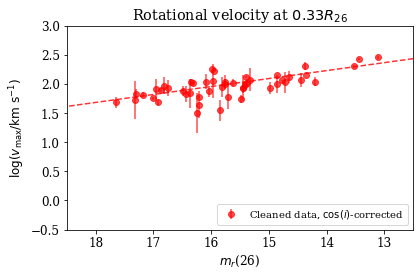

In [53]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

a, b, _ = bestfit.x
r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.8)

ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity at $0.33R_{26}$')

ax.legend(loc='lower right', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
fig.savefig('tf_coma.png', dpi=120)

# print(np.sum(isrmeas))

### Iteratively fit and remove objects further than 3$\sigma$

In [34]:
def fit_3sigma(x,y,dy):
    '''
    Iterative linear fit that removes points outside 3sigma of the fit until 
    convergence (no more points removed).
    '''
    
    # Number of points to fit
    N = len(x)
    
    # Initialize variable to store the number of points fit in the last iteration
    N_last = np.inf
    
    while (N < N_last) and (N > 1):
        
        # Update N_last
        N_last = N
        
        # Fit
        a, b, linf, hess_inv = fit_tfr(x, y, dy)
        
        ########################################################################
        # Remove all points that are outside 3-sigma of the fit
        #-----------------------------------------------------------------------
        remove_points = []
        
        for i in range(N):
            ####################################################################
            # Calculate expected value at this point
            #-------------------------------------------------------------------
            y_fit = a + b*x[i]
            ####################################################################
            
            
            ####################################################################
            # Calculate sigma at this point
            #-------------------------------------------------------------------
            random_sample = np.random.multivariate_normal(mean=(a,b), 
                                                          cov=hess_inv.matmat(np.eye(2)), 
                                                          size=1000)
            
            y_random = random_sample[:,0] + random_sample[:,1]*x[i]
            
            std_dev = np.std(y_random)
            ####################################################################
            
            
            if np.abs(y_fit - y[i]) > 3*std_dev:
                remove_points.append(i)
        ########################################################################
        
        
        ########################################################################
        # Update points if needed
        #-----------------------------------------------------------------------
        if len(remove_points) > 0:
            x = np.delete(x, remove_points)
            y = np.delete(y, remove_points)
            dy = np.delete(dy, remove_points)
            
            N = len(x)
        ########################################################################
    
    return a, b, hess_inv

Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 5.29540509098671, 'jac': array([  0.85523837, -48.18584743]), 'nfev': 291, 'njev': 97, 'nit': 21, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 4.2692078 , -0.14654133]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 3.0065986811301277, 'jac': array([  1.      , -14.496597]), 'nfev': 387, 'njev': 129, 'nit': 24, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 4.08593478, -0.13402758]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 7.331619977790638e-08, 'jac': array([  0.        , -21

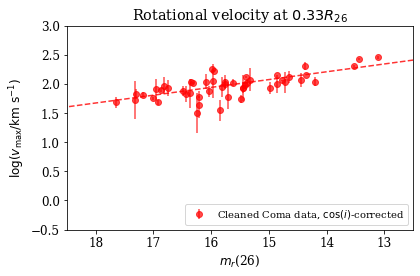

In [36]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)


################################################################################
# Original data
# #-------------------------------------------------------------------------------
# print('Original')

# # ax.errorbar(rmag[isrmeas], 
# #             log10vmax[isrmeas], 
# #             yerr=dlog10vmax[isrmeas], 
# #             fmt='ko', 
# #             alpha=0.2,
# #             label='Coma data')

# a, b, hess_inv = fit_3sigma(rmag[isrmeas], 
#                             log10vmax[isrmeas], 
#                             dlog10vmax[isrmeas])
# print(a,b)

# r = np.arange(12.5,18.6,0.1)
# ax.plot(r, a + b*r, 'k--', alpha=0.2)
################################################################################


################################################################################
# Cleaned data
# -------------------------------------------------------------------------------
# print('\nCleaned')

rmag_clean = np.asarray(rmag_clean_new)
vmax_clean = np.asarray(vmax_clean_new)
dvmax_clean = np.asarray(dvmax_clean_new)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned Coma data, $\cos{(i)}$-corrected')

a, b, hess_inv = fit_3sigma(rmag_clean[isrmeas_clean], 
                            log10vmax_clean[isrmeas_clean], 
                            dlog10vmax_clean[isrmeas_clean])
# print(a,b)

uncertainty = np.sqrt(np.diag(hess_inv.todense()))
labels = ['y-intercept', 'slope']
params = [a, b]
for i in range(2):
    print('{:<6s} = {:9.4f} +- {:6.4f}'.format(labels[i], params[i], uncertainty[i]))
r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.8)
################################################################################


ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity at $0.33R_{26}$')

ax.legend(loc='lower right', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
# fig.savefig('tf_coma_cleaned.png', dpi=120, transparent=True)

# print(np.sum(isrmeas))

### Make pretty plot of just cleaned data with best fit

<ipython-input-49-6325b4a7720b>:26: RuntimeWarning: covariance is not positive-semidefinite.
  random_samples = np.random.multivariate_normal(mean=(a,b),


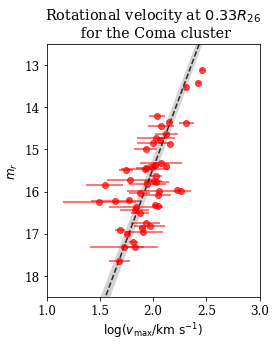

In [49]:
fig, ax = plt.subplots(1,1, figsize=(4,5), tight_layout=True)

rmag_clean = np.asarray(rmag_clean_new)
vmax_clean = np.asarray(vmax_clean_new)
dvmax_clean = np.asarray(dvmax_clean_new)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean

r = np.arange(12.5,18.6,0.1)
v = a + b*r

################################################################################
# Compute and plot the uncertainty range around the best fit
#-------------------------------------------------------------------------------
hessian = ndt.Hessian(l1norm)
hess = hessian((a,b), 
               rmag_clean[isrmeas_clean], 
               log10vmax_clean[isrmeas_clean], 
               dlog10vmax_clean[isrmeas_clean])

N_samples = 1000

random_samples = np.random.multivariate_normal(mean=(a,b), 
                                               cov=np.linalg.inv(np.abs(hess)), #hess_inv.matmat(np.eye(2)), 
                                               size=N_samples)

y_samples = np.zeros([1000, len(r)])
for i in range(len(r)):
    y_samples[:,i] = random_samples[:,0] + random_samples[:,1]*r[i]

std_dev = np.std(y_samples, axis=0)

ax.fill_betweenx(r, v-std_dev, v+std_dev, facecolor='lightgray')
################################################################################

ax.plot(v, r, 'k--', alpha=0.8)

ax.errorbar(log10vmax_clean[isrmeas_clean], 
            rmag_clean[isrmeas_clean], 
            xerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7)

ax.set(ylabel='$m_r$',
       ylim=(18.5, 12.5),
       xlabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       xlim=(1,3),
       title='Rotational velocity at $0.33R_{26}$ \n for the Coma cluster');

plt.savefig('tf_coma_cleaned_m_vs_vmax.png', dpi=120);